In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random
import math

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, LSTM, Bidirectional, Dropout, Concatenate
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint
import keras.backend as K

2024-05-19 22:05:27.154130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 22:05:27.718698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-19 22:05:27.718739: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-19 22:05:27.798015: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 22:05:29.185066: W tensorflow/stream_executor/platform/de

In [3]:
import re

In [4]:
info = pd.DataFrame({})

In [5]:
# Load CSV with the metadata of each sensor file

for folder_distance in ['tutorial_12cm']:
    info_aux = pd.read_csv(str(folder_distance) + '/file_data.csv')
    info_aux['distance'] = int(re.findall(r'\d+',folder_distance)[0])/100
    info = pd.concat([info, info_aux])

In [6]:
# This function is used mainly to join the original
# bitstream information to each file. It also creates 
# columns for visualization

def add_inputs_labels(df,row,i,injection_time,injection_amount,bit_duration):
    input_name = 'input_' + str(i)
    bitstream_name = 'bitstream_' + str(i)
    
    df[input_name] = 0
    df[bitstream_name] = row[bitstream_name][1:]

    time_add = 0
    for count, bit in enumerate(row[bitstream_name][1:].split()[0]):
        df.loc[(df.sim_time <= injection_time + time_add) & (df.sim_time >= time_add),input_name] = injection_amount*int(bit)
        time_add += bit_duration
    return df

In [7]:
# Load data from each sensor csv into a dataframe dictionary

data = {}

for index,row in info.sample(frac=1).reset_index(drop=True).iterrows():
    data_aux = pd.read_csv("~"+row['file_location'].replace("'",""))
    data_aux = data_aux[:] #Clip data
    data_aux = data_aux[::10].reset_index(drop=True) #Downsample data
    for i in range(0,1):
        add_inputs_labels(data_aux,row,i,0.1,1000,1)
    data_aux['distance'] = row['distance']
    data.update({index: data_aux})


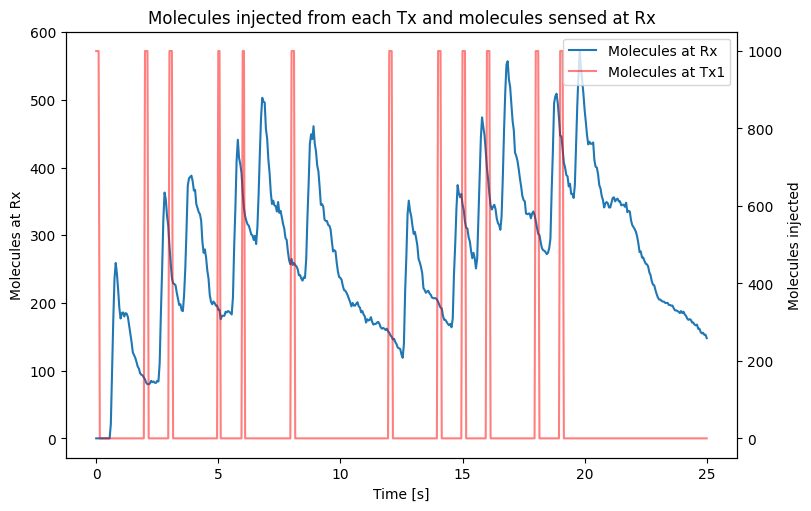

In [8]:
#Visualize each dataset
chosen_dataset = 88

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'molecule_count'
y_axis_2 = 'input_0'
#y_axis_3 = 'input_1'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False, label = "Molecules at Tx1")
#sel_dataset.plot(x=x_axis, y=y_axis_3, ax=ax2, color='green', alpha=0.5, legend=False, label = "Molecules at Tx2")
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False, label = "Molecules at Rx")
#ax.text(max_x_axis*0.8, max_y_axis*0.8, 'd = %f'%(data[chosen_dataset]['distance'][0]), style='italic',
#        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})


plt.title("Molecules injected from each Tx and molecules sensed at Rx")
#ax.legend(loc='upper right')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Molecules at Rx")
ax2.set_ylabel("Molecules injected")

ax2.legend(lines + lines2, labels + labels2, loc='upper right')
                
fig.tight_layout(pad=.3)
fig.savefig("single_source_ml.png", dpi=300)

In [9]:
# Create the input and output matrix
    
x_all = np.zeros((len(data),data[0]['molecule_count'].size))
y_all = np.zeros((len(data),1))
y_all_bitstream = np.zeros((len(data),len([int(i) for i in data[0]['bitstream_0'][0]])))

for i in range(0,len(data)):
    x_all[i] = data[i]['molecule_count']
    y_all[i] = [data[i]['distance'][0]]
    y_all_bitstream[i] = [int(i) for i in data[i]['bitstream_0'][0]]


In [10]:
from scipy.optimize import minimize

# Specify parameters of simulation

data_rate = 1
N_tx = 1000
v_eff = 0.09 # m/s
rx_length = 0.035 #m
tx_length = 0.01 #m
t_i = np.arange(0,25,0.05)

# Select model to test

model_chosen = 6

sequence = y_all_bitstream[model_chosen]
x_first_test = x_all[model_chosen]

# Impulse response according to eq. 16 of Duct Flow paper

def ob_prob(d,v_eff,rx_length,t):
    t_1 = (d)/(2*v_eff)
    t_2 = (d+rx_length+tx_length)/(2*v_eff)

    if t>=t_1 and t<=t_2:
        return 1 - (d)/(2*v_eff*t)
    if t > t_2:
        return (rx_length+tx_length)/(2*v_eff*t)
    else: 
        return 0

# We sum the probabilities of each impulse response for each bit in the sequence at certain t
def mean_mol_number(N_tx,d,sequence,t):
    aux = 0
    
    for i in range(0,len(sequence)):
        aux = aux + sequence[i]*ob_prob(d,v_eff,rx_length,t-i*data_rate)
        
    if aux > 0:
        return N_tx*aux
    else:
        return 0.000001
    

def neg_log_likelihood(d,data):
    
    log_likelihood = 0
    
    print("Distance between source and receiver is: " + str(d[0]) + " m")
    
    for i in range(0,len(t_i)):
        log_likelihood = log_likelihood + data[i]*math.log(mean_mol_number(N_tx,d,sequence,t_i[i])) - mean_mol_number(N_tx,d,sequence,t_i[i]) - math.log(math.factorial(int(data[i])))
    
    return -log_likelihood

def negative_log_likelihood_jac(d,x_first_test):
     x = x_first_test
    
     residuals = x - d
     jac = -np.sum(residuals)
    
     return jac


# Initial d_tx guess
initial_params = [0.1]

# Use the L-BFGS-B optimization method to maximize the Poisson likelihood
result = minimize(neg_log_likelihood, initial_params, args=(x_first_test,), method='Nelder-Mead')

# Extract the optimized parameter
optimized_rate = result.x[0]

print("Optimized Distance:", optimized_rate)
print("Actual Distance:", data[model_chosen]['distance'][0])

Distance between source and receiver is: 0.1 m
Distance between source and receiver is: 0.10500000000000001 m
Distance between source and receiver is: 0.11000000000000001 m
Distance between source and receiver is: 0.10250000000000001 m
Distance between source and receiver is: 0.10750000000000001 m
Distance between source and receiver is: 0.11000000000000004 m
Distance between source and receiver is: 0.11000000000000001 m
Distance between source and receiver is: 0.10625000000000001 m
Distance between source and receiver is: 0.10500000000000001 m
Distance between source and receiver is: 0.10687500000000001 m
Distance between source and receiver is: 0.10750000000000001 m
Distance between source and receiver is: 0.1065625 m
Distance between source and receiver is: 0.10718750000000002 m
Distance between source and receiver is: 0.10703125000000002 m
Distance between source and receiver is: 0.10671875 m
Distance between source and receiver is: 0.10695312500000001 m
Distance between source and

In [12]:
from scipy.stats import poisson

In [13]:
data_rate = 1
N_tx = 2000
v_eff = 0.09 # m/s
rx_length = 0.035

model_chosen = 20

sequence = y_all_bitstream[model_chosen]
x_first_test = x_all[model_chosen]

t_i = np.arange(0,25,0.05)

d = 0.12

n_exp_mol = [poisson.rvs(mean_mol_number(N_tx,d,sequence,i),1) for i in t_i]


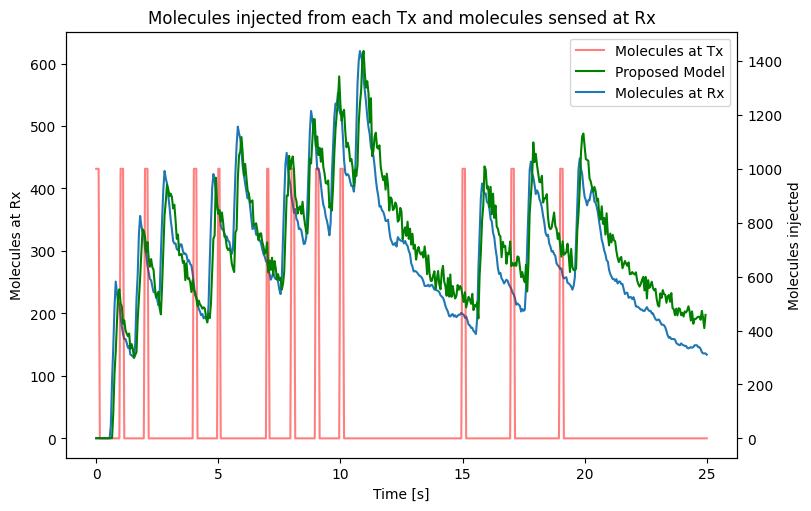

In [14]:
#Visualize each dataset
chosen_dataset = 20

sel_dataset = data[chosen_dataset]
x_axis = 'sim_time'
y_axis_1 = 'molecule_count'
y_axis_2 = 'input_0'


max_x_axis = sel_dataset[x_axis].max()
max_y_axis = sel_dataset[y_axis_1].max()

fig, ax = plt.subplots(figsize=(8, 5))
ax2 = ax.twinx()
sel_dataset.plot(x=x_axis, y=y_axis_2, ax=ax2, color='red', alpha=0.5, legend=False, label = "Molecules at Tx")
sel_dataset.plot(x=x_axis, y=y_axis_1, ax=ax, legend=False, label = "Molecules at Rx")
plt.plot(t_i,n_exp_mol,color='green', label = "Proposed Model")

plt.title("Molecules injected from each Tx and molecules sensed at Rx")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax.set_xlabel("Time [s]")
ax.set_ylabel("Molecules at Rx")
ax2.set_ylabel("Molecules injected")

ax2.legend(lines2 + lines, labels2 + labels, loc='upper right')
                
fig.tight_layout(pad=.3)
fig.savefig("one_source_even_longer_Tx.png", dpi=300)

In [55]:
poi_approx = np.zeros(99)
empirical_value = np.zeros(99)

In [56]:
for i in range(0,99):
    t = np.where(y_all_bitstream[i]==1)[0][0]*data_rate+1.2
    t_d = round(t/0.05)
    
    sequence = y_all_bitstream[i]
    
    poi_approx[i] = poisson.rvs(mean_mol_number(N_tx,d,sequence,t),1)
    empirical_value[i] = x_all[i][t_d]

In [57]:
# Number of molecules at Rx at time 1.2s per experiment

empirical_value.mean()

164.1919191919192

In [63]:
poi_approx.mean()/2

276.7323232323232

In [59]:
bins_sep = [i for i in range(100,210,5)]

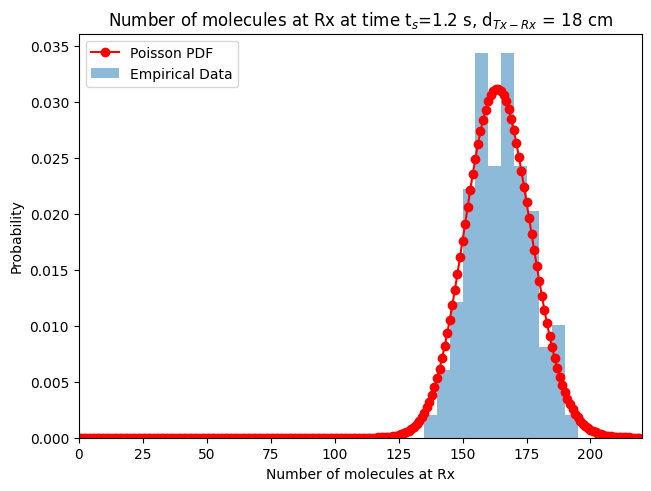

In [61]:
#plt.hist((poi_approx/3.1),bins=bins_sep, alpha=0.5, density=True, label="Poisson")
#plt.plot(x_values, poisson_distribution, 'r', label='Poisson Distribution')

x = np.arange(0, 220)

plt.plot(x, poisson.pmf(x, mu=164), 'ro-', label='Poisson PDF')
plt.hist(empirical_value, bins=bins_sep, alpha=0.5, density=True, label="Empirical Data")
plt.title("Number of molecules at Rx at time t$_s$=1.2 s, d$_{Tx-Rx}$ = 18 cm")
plt.xlabel("Number of molecules at Rx")
plt.ylabel("Probability")

plt.xlim(0,220)
plt.legend()
plt.tight_layout(pad=.3)
plt.savefig("one_source_20cm_Tx_5cm.png", dpi=300)